In [ ]:
!pip install sightengine

In [ ]:
from google.colab import drive
from google.colab import files
from sightengine.client import SightengineClient
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from time import time
import matplotlib.patheffects as path_effects
import shutil
import random
import multiprocessing as mp
import glob
import pickle

# Nothing important, just to make colors white
# to see them better, since the background is gray
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
          "text.color" : "c"}
plt.rcParams.update(params)
%matplotlib inline

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/data_')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Function definitions for parameters

### Brightness Function

In [ ]:
def brightness(image):
    return np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2YUV)[:,:,0]) / 255.0

### Sharpness Function

In [ ]:
def sharpness(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5) # 5x5
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5) # 5x5
    G = np.sqrt((sobelx ** 2 + sobely ** 2))
    S = G.mean()

    # Mapping
    C1 = [0.01973334, 5.00009004]
    C2 = [0.00250833, 0.77154772]
    S = np.log(S)
    S = S - C1[1]
    S = (S / C1[0]) * C2[0]
    S = S + C2[1]

    return min(S, 1.0)

### Contrast Function

In [ ]:
from skimage import io
from skimage import exposure
from skimage import color
from skimage import img_as_float
from sklearn.metrics import mutual_info_score as mis
def pycontrast(input_image, num_bins=128):
    """
    Computes a score of the quality of contrast in input image based on divergence
    from an intensity equalized histogram.
    We compute the mutual information (MI) (a measure of entropy) between histogram of intensity
    of image and its contrast equalized histogram.
    MI is not real metric, but a symmetric and non-negative similarity measures that
    takes high values for similar images. Negative values are also possible.
    Intuitively, mutual information measures the information that histogram_image and histogram_equlized
    share: it measures how much knowing one of these variables reduces uncertainty about the other.
    The Entropy is defined as:
    .. math::
        H(X) = - \sum_i p(g_i) * ln(p(g_i)
    with :math:`p(g_i)` being the probability of the images intensity value :math:`g_i`.
    Assuming two histograms :math:`R` and :math:`T`, the mutual information is then computed by comparing the
    histogram entropy values (i.e. a measure how well-structured the common histogram is).
    The distance metric is then calculated as follows:
    .. math::
        MI(R,T) = H(R) + H(T) - H(R,T) = H(R) - H(R|T) = H(T) - H(T|R)
    A maximization of the mutual information is equal to a minimization of the joint
    entropy.
    :param input_image : 2-D array
    :param num_bins :  integer : the number of bins in histogram, it has a small scaling effect on
    the mutual information score since it slightly modifies the shape of the histogram
    :return: quality of contrast : float
    :raises: argument error if input image data is corrupted
    """

    # Check dimensions of input image
    # If image dimensions is 2, then it is a gray-scale image
    # First convert input to RGB image
    if input_image.shape == 2:
        input_image = color.gray2rgb(input_image)

    # Convert the RGB image to HSV. Exposure is primarily correlated with Value rather
    # than Hue and Saturation
    image_hsv = color.rgb2hsv(input_image)

    # The intensity channel is third in HSV format image
    v_channel = image_hsv[:, :, 2]

    # compute the contrast equalized array of intensity channel of image
    v_channel_equalized = exposure.equalize_hist(v_channel, nbins=num_bins)

    # compute the histogram of intensity channel
    v_channel_histogram, histogram_bin_edges = np.histogram(img_as_float(v_channel), bins=num_bins, density=True)

    # compute the histogram of contrast equalized intensity channel
    v_channel_equalized_histogram, _ = np.histogram(img_as_float(v_channel_equalized), bins=num_bins, density=True, range=(histogram_bin_edges[0], histogram_bin_edges[-1]))

    # compute the mutual information based contrast quality measure
    return mis(v_channel_histogram, v_channel_equalized_histogram)

def contrast(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return min(pycontrast(image) / 5, 1.0)

# Utility Functions

In [ ]:
def outline(color='black', *text):
    if text is None or len(text) == 0:
        return
    if len(text) > 1:
        for t in text:
            outline(color, t)
        return
    text[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color),
                                path_effects.Normal()])

In [ ]:
def upload_files():
    uploaded = files.upload()
    for k, v in uploaded.items():
        open(k, 'wb').write(v)
    return list(uploaded.keys())

# Loading 100 images randomly

In [ ]:
paths = list(filter(os.path.isfile, glob.glob('train/*/*.jpg') + glob.glob('train/*/*.JPG')))
random.shuffle(paths)
test_paths = paths[:100]
def import_image(path):
    return path, cv2.imread(path)
images = list(map(import_image, test_paths))

# Loading SightEngine values

In [ ]:
client = SightengineClient('54728470', 'HWFs4bVA7cvcdqL9sW7x')

google_values = []
for i, (path, image) in enumerate(images):

    google_values_path = '../train_google_values/' +  '/'.join(path.split('/')[1:])[:-4] + '.pkl'

    if os.path.exists(google_values_path):
        try:
            print(f'Trying to read from the cache {google_values_path} at image {i+1}')
            with open(google_values_path, 'rb') as file:
                output = pickle.load(file)
        except EOFError:
            print(f'Couldn\'t read, using SightEngine')
            # TODO: safety check if sightengine api limit exceeded
            output = client.check('properties').set_file(path)
            with open(google_values_path, 'wb') as file:
                pickle.dump(output, file)
    else:
        # TODO: safety check if sightengine api limit exceeded
        output = client.check('properties').set_file(path)
        with open(google_values_path, 'wb') as file:
            pickle.dump(output, file)
    
    google_values.append(output)

Trying to read from the cache ../train_google_values/Bedroom/bedroom (142).pkl at image 8
Trying to read from the cache ../train_google_values/Bedroom/bedroom (108).pkl at image 9
Trying to read from the cache ../train_google_values/Line/line (29).pkl at image 12
Trying to read from the cache ../train_google_values/Room/room (252).pkl at image 13
Trying to read from the cache ../train_google_values/Kitchen/kitchen (316).pkl at image 15
Trying to read from the cache ../train_google_values/Room/room (148).pkl at image 41
Trying to read from the cache ../train_google_values/Livingroom/livingroom (164).pkl at image 45
Trying to read from the cache ../train_google_values/Livingroom/livingroom (1070).pkl at image 46
Trying to read from the cache ../train_google_values/Bathroom/bathroom  (146).pkl at image 48
Trying to read from the cache ../train_google_values/Line/line (30).pkl at image 50
Trying to read from the cache ../train_google_values/Bathroom/bathroom  (316).pkl at image 52
Trying t

# Comparing Function

In [ ]:
def compare(google_value, path, image, show=True):

    mbt = r"$\bf{Ours:}$ %.3f" % brightness(image)
    gbt = r"$\bf{Google's:}$ %.3f" % google_value['brightness']

    mct = r"$\bf{Ours:}$ %.3f" % contrast(image)
    gct = r"$\bf{Google's:}$ %.3f" % google_value['contrast']
    
    mst = r"$\bf{Ours:}$ %.3f" % sharpness(image)
    gst = r"$\bf{Google's:}$ %.3f" % google_value['sharpness']

    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        ax1.imshow(image[:,:,::-1])
        ax2.imshow(np.ones((50, 100)) * 35, cmap='gray', vmin=0, vmax=255)
        # Brightness Title
        outline('black',
                ax2.text(15, 17, 'Brightness', color='r', fontweight='bold',
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center'))
        # Brightness Values
        ax2.text(15, 25, f'{gbt}\n{mbt}', color='w', fontsize=12,
                horizontalalignment='center', verticalalignment='center')
        # Sharpness Title
        outline('black',
                ax2.text(50, 17, 'Sharpness', color='r', fontweight='bold',
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center'))
        # Sharpness Values
        ax2.text(50, 25, f'{gst}\n{mst}', color='w', fontsize=12,
                horizontalalignment='center', verticalalignment='center')
        # Contrast Title
        outline('black',
                ax2.text(85, 17, 'Contrast', color='r', fontweight='bold',
                        fontsize=14, horizontalalignment='center',
                        verticalalignment='center'))
        # Contrast Values
        ax2.text(85, 25, f'{gct}\n{mct}', color='w', fontsize=12,
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xticks([], [])
        ax2.set_yticks([], [])
        plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


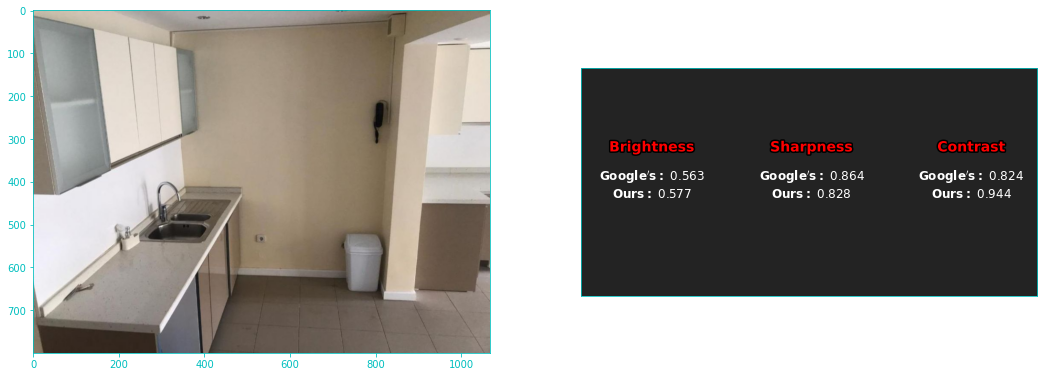

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


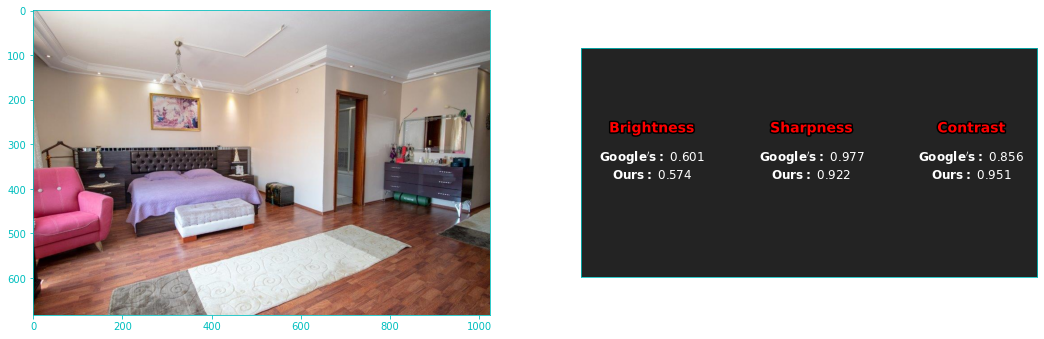

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


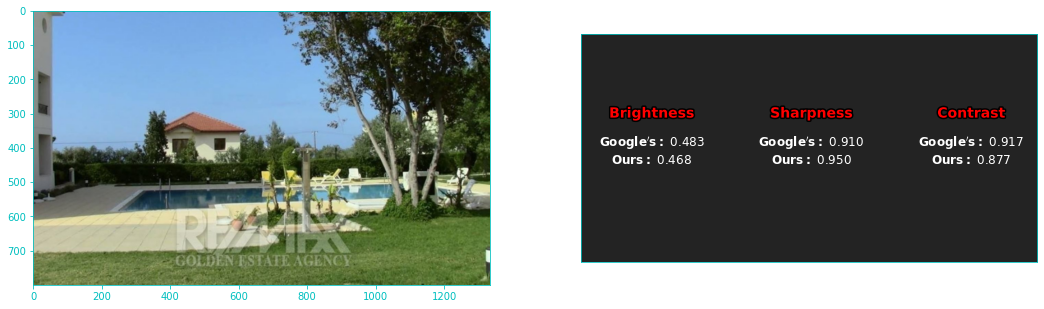

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


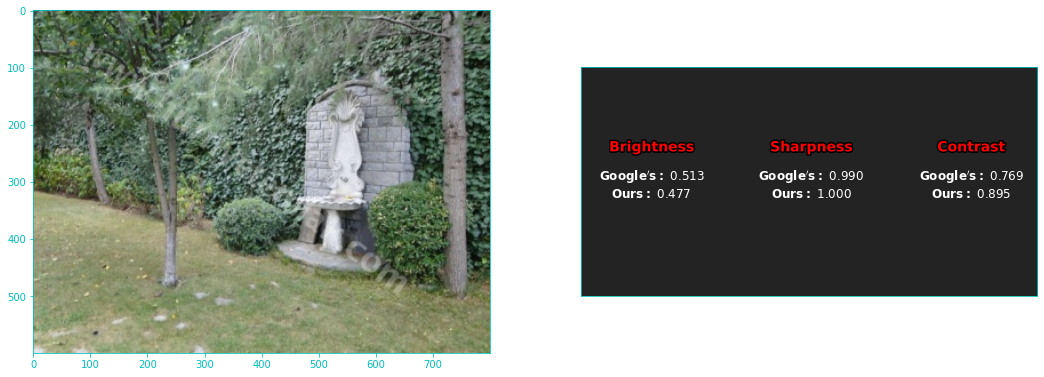

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


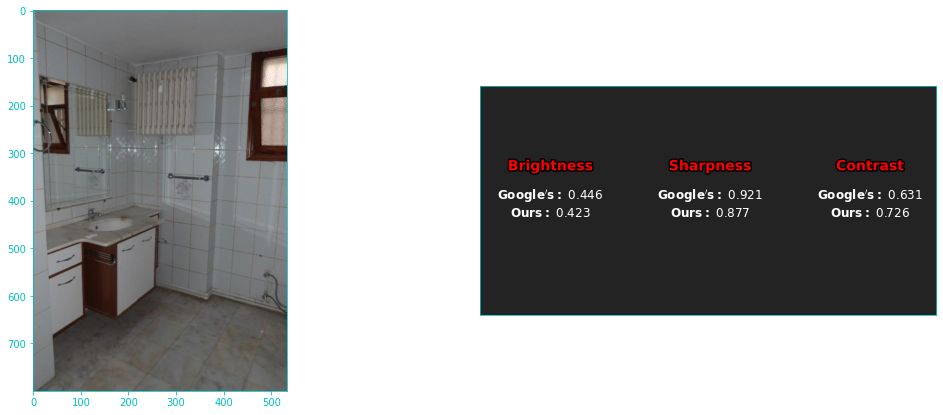

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


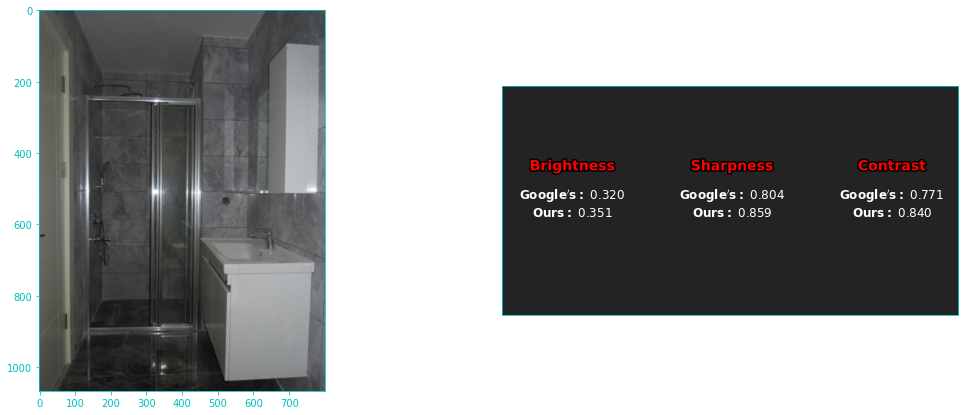

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


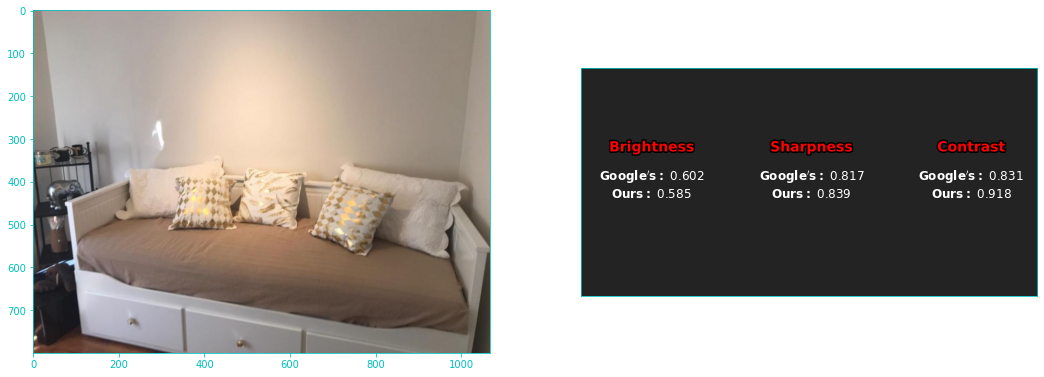

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


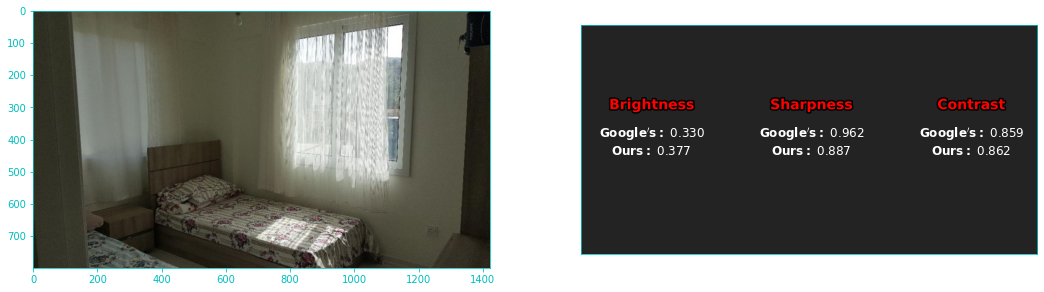

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


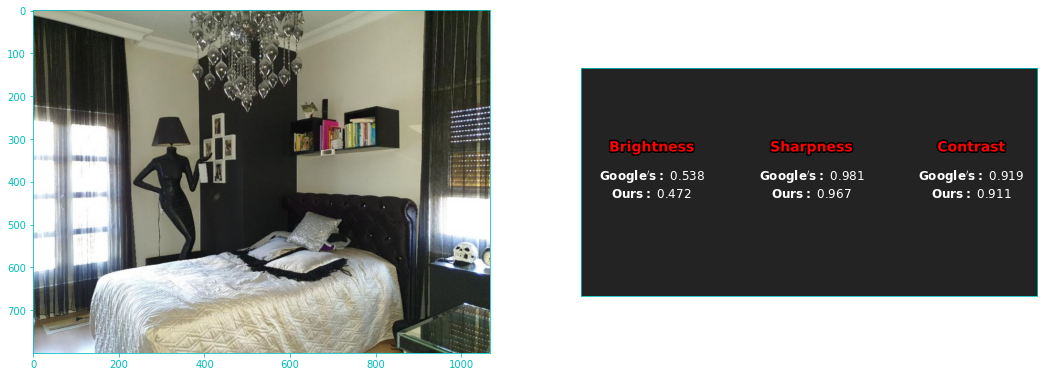

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


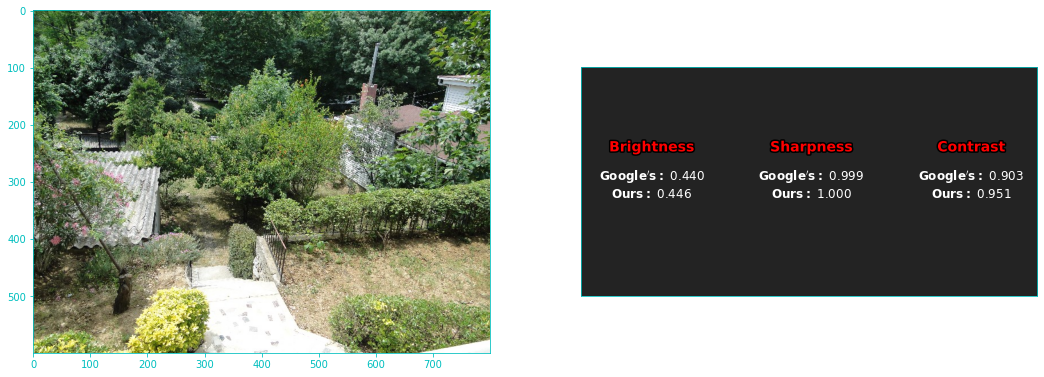

In [ ]:
for google_value, (path, image) in zip(google_values[:10], images):
    compare(google_value, path, image)

# Parameter Plots

In [ ]:
def plot(func, sort=True):
    param_name = func.__name__
    ours = np.array([func(image[1]) for image in images])
    google = np.array([val[param_name] for val in google_values])
    # Sorting both values based on google values
    if sort:
        sorted_indices = ours.argsort()
        ours = ours[sorted_indices]
        google = google[sorted_indices]
    # Actual plotting
    x = np.arange(100)
    plt.figure(figsize=(14, 7))
    plt.scatter(x, ours, label=f'Our {param_name.title()} Values', alpha=0.7)
    plt.scatter(x, google, label=f'SightEngine\'s {param_name.title()} Values', alpha=0.7)
    plt.ylim(0, 1)
    plt.xlabel('Image index', color='c', fontsize=14, fontweight='bold')
    plt.ylabel(param_name.title(), color='c', fontsize=14, fontweight='bold')
    l = plt.legend()
    for text in l.get_texts():
        text.set_color('k')
    plt.show()

### Comparing brightness values for random 100 images

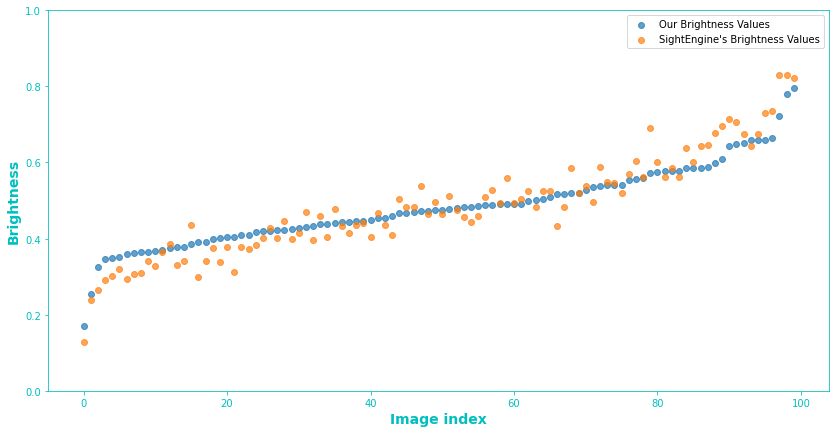

In [ ]:
plot(brightness)

### Comparing sharpness values for random 100 images

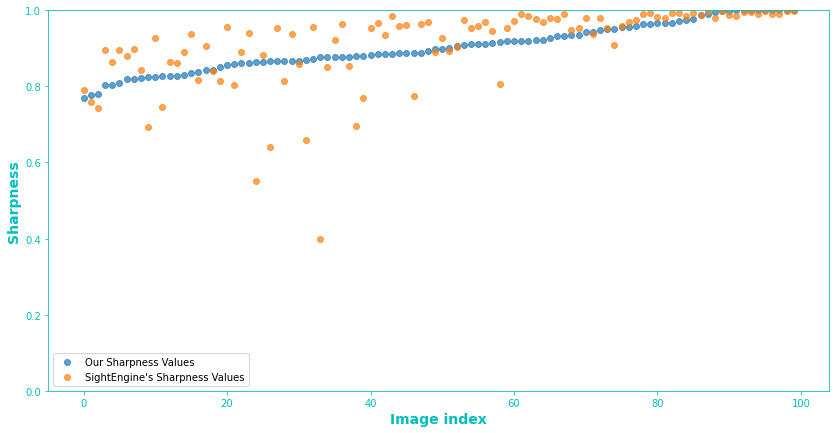

In [ ]:
plot(sharpness)

### Comparing contrast values for random 100 images

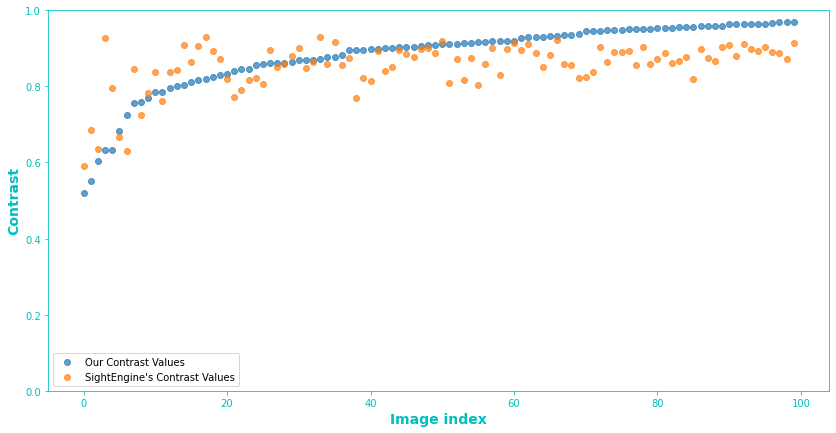

In [ ]:
plot(contrast)